# Run this notebook under a TPU environment

Imported required libraries and check their versions

In [1]:
import gc
import os
import math
import numpy as np
import pandas as pd
from numba import njit
from numpy import sqrt, sin, cos, pi, zeros
from numpy.random import randn, rand, uniform, normal
from scipy.linalg import hadamard
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation, LSTM, Dropout, RepeatVector, TimeDistributed, Embedding, Reshape, Dot, Concatenate
from tensorflow.keras.layers import GRU, SpatialDropout1D, Conv1D, GlobalMaxPooling1D,Multiply, Lambda, Softmax, Flatten, BatchNormalization, Bidirectional, dot, concatenate
from tensorflow.keras.layers import AdditiveAttention, Attention
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras import backend
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import MeanSquaredError
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.6.0


Detect hardware if TPU exists

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.78.73.18:8470
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.78.73.18:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.78.73.18:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


Read the csv file. Otherwise follow its link, download it and upload it to the left console manually.

In [6]:
!wget https://www.mediafire.com/file/atjoiman6jfuhp0/lotto_history.csv/file
lotto = pd.read_csv('lotto_history.csv', index_col = 'Date')
print(lotto)

--2021-08-31 08:05:44--  https://drive.google.com/file/d/10r5Nar7yQtGFk-src7lqPz7AjmCev2GO/view?usp=sharing
Resolving drive.google.com (drive.google.com)... 172.217.219.138, 172.217.219.100, 172.217.219.102, ...
Connecting to drive.google.com (drive.google.com)|172.217.219.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://accounts.google.com/ServiceLogin?service=wise&passive=1209600&continue=https://drive.google.com/file/d/10r5Nar7yQtGFk-src7lqPz7AjmCev2GO/view?usp%3Dsharing&followup=https://drive.google.com/file/d/10r5Nar7yQtGFk-src7lqPz7AjmCev2GO/view?usp%3Dsharing [following]
--2021-08-31 08:05:44--  https://accounts.google.com/ServiceLogin?service=wise&passive=1209600&continue=https://drive.google.com/file/d/10r5Nar7yQtGFk-src7lqPz7AjmCev2GO/view?usp%3Dsharing&followup=https://drive.google.com/file/d/10r5Nar7yQtGFk-src7lqPz7AjmCev2GO/view?usp%3Dsharing
Resolving accounts.google.com (accounts.google.com)... 142.250.125.84, 2607:f8

Train-test split

In [7]:
data = lotto.values - 1
train = data[:-50]
test = data[-50:]

w = 10
X_train = []
y_train = []
for i in range(w, len(train)):
    X_train.append(train[i - w: i, :])
    y_train.append(train[i])
X_train, y_train = np.array(X_train), np.array(y_train)

inputs = data[data.shape[0] - test.shape[0] - w:]
X_test = []
for i in range(w, inputs.shape[0]):
    X_test.append(inputs[i - w: i, :])
X_test = np.array(X_test)
y_test = test

print(data.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(485, 7)
(425, 10, 7)
(425, 7)
(50, 10, 7)
(50, 7)


Seq2Seq Model to Predict Future Draws

In [9]:
embed_dim = (59 // 2) + 1
dropout_rate = 0.5
spatial_dropout_rate = 0.5
steps_before = w
steps_after = 7
feature_count = embed_dim * 7
hidden_neurons = [64, 32] 
bidirectional = True 
attention_style = 'Bahdanau'

#%%

with strategy.scope():
    
    inp0 = Input(shape = (w, X_train.shape[2]))
    
    # Embed 59 categories into a 30-dimension continuous-number vector for each ball
    inp1 = Lambda(lambda x: x[:, :, 0])(inp0)
    inp1 = Embedding(59, embed_dim)(inp1)
    inp1 = SpatialDropout1D(spatial_dropout_rate)(inp1)
    
    inp2 = Lambda(lambda x: x[:, :, 1])(inp0)
    inp2 = Embedding(59, embed_dim)(inp2)
    inp2 = SpatialDropout1D(spatial_dropout_rate)(inp2)
    
    inp3 = Lambda(lambda x: x[:, :, 2])(inp0)
    inp3 = Embedding(59, embed_dim)(inp3)
    inp3 = SpatialDropout1D(spatial_dropout_rate)(inp3)
    
    inp4 = Lambda(lambda x: x[:, :, 3])(inp0)
    inp4 = Embedding(59, embed_dim)(inp4)
    inp4 = SpatialDropout1D(spatial_dropout_rate)(inp4)
    
    inp5 = Lambda(lambda x: x[:, :, 4])(inp0)
    inp5 = Embedding(59, embed_dim)(inp5)
    inp5 = SpatialDropout1D(spatial_dropout_rate)(inp5)    
    
    inp6 = Lambda(lambda x: x[:, :, 5])(inp0)
    inp6 = Embedding(59, embed_dim)(inp6)
    inp6 = SpatialDropout1D(spatial_dropout_rate)(inp6)
    
    inp7 = Lambda(lambda x: x[:, :, 6])(inp0)
    inp7 = Embedding(59, embed_dim)(inp7)
    inp7 = SpatialDropout1D(spatial_dropout_rate)(inp7)
    
    inp = Concatenate()([inp1, inp2, inp3, inp4, inp5, inp6, inp7])
    
    # Seq2Seq model with attention or bidirectional encoder
    
    num_layers = len(hidden_neurons)
    
    sh_list, h_list, c_list = [inp], [], []
    
    if bidirectional:
        
        for i in range(num_layers):
    
            sh, fh, fc, bh, bc = Bidirectional(LSTM(hidden_neurons[i],
                                                    dropout = dropout_rate, 
                                                    return_state = True, 
                                                    return_sequences = True))(sh_list[-1])
        
            h = Concatenate()([fh, bh])
            c = Concatenate()([fc, bc]) 

            sh_list.append(sh)
            h_list.append(h)
            c_list.append(c)
        
    else:
    
        for i in range(num_layers):

            sh, h, c = LSTM(hidden_neurons[i], 
                            dropout = dropout_rate,
                            return_state = True, 
                            return_sequences = True)(sh_list[-1])

            sh_list.append(sh)
            h_list.append(h)
            c_list.append(c)
    
    decoder = RepeatVector(steps_after)(h_list[-1])
    
    if bidirectional:
        
        decoder_hidden_neurons = [hn * 2 for hn in hidden_neurons]
        
    else:
        
        decoder_hidden_neurons = hidden_neurons
    
    for i in range(num_layers):
        
        decoder = LSTM(decoder_hidden_neurons[i],
                       dropout = dropout_rate, 
                       return_sequences = True)(decoder, initial_state = [h_list[i], c_list[i]])
       
    if attention_style == 'Bahdanau':
        
        context = AdditiveAttention(dropout = dropout_rate)([decoder, sh_list[-1]])
        
        decoder = concatenate([context, decoder])
        
    elif attention_style == 'Luong':
        
        context = Attention(dropout = dropout_rate)([decoder, sh_list[-1]])
        
        decoder = concatenate([context, decoder])
    
    out = Dense(59, activation = 'softmax')(decoder)

    model = Model(inputs = inp0, outputs = out)
    
    sparse_top_k = tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 5, name = 'sparse_top_k')

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = [sparse_top_k])

    #%%

    model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 7)]      0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 10)           0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 10)           0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 10)           0           input_1[0][0]                    
______________________________________________________________________________________________

visualise the model summary

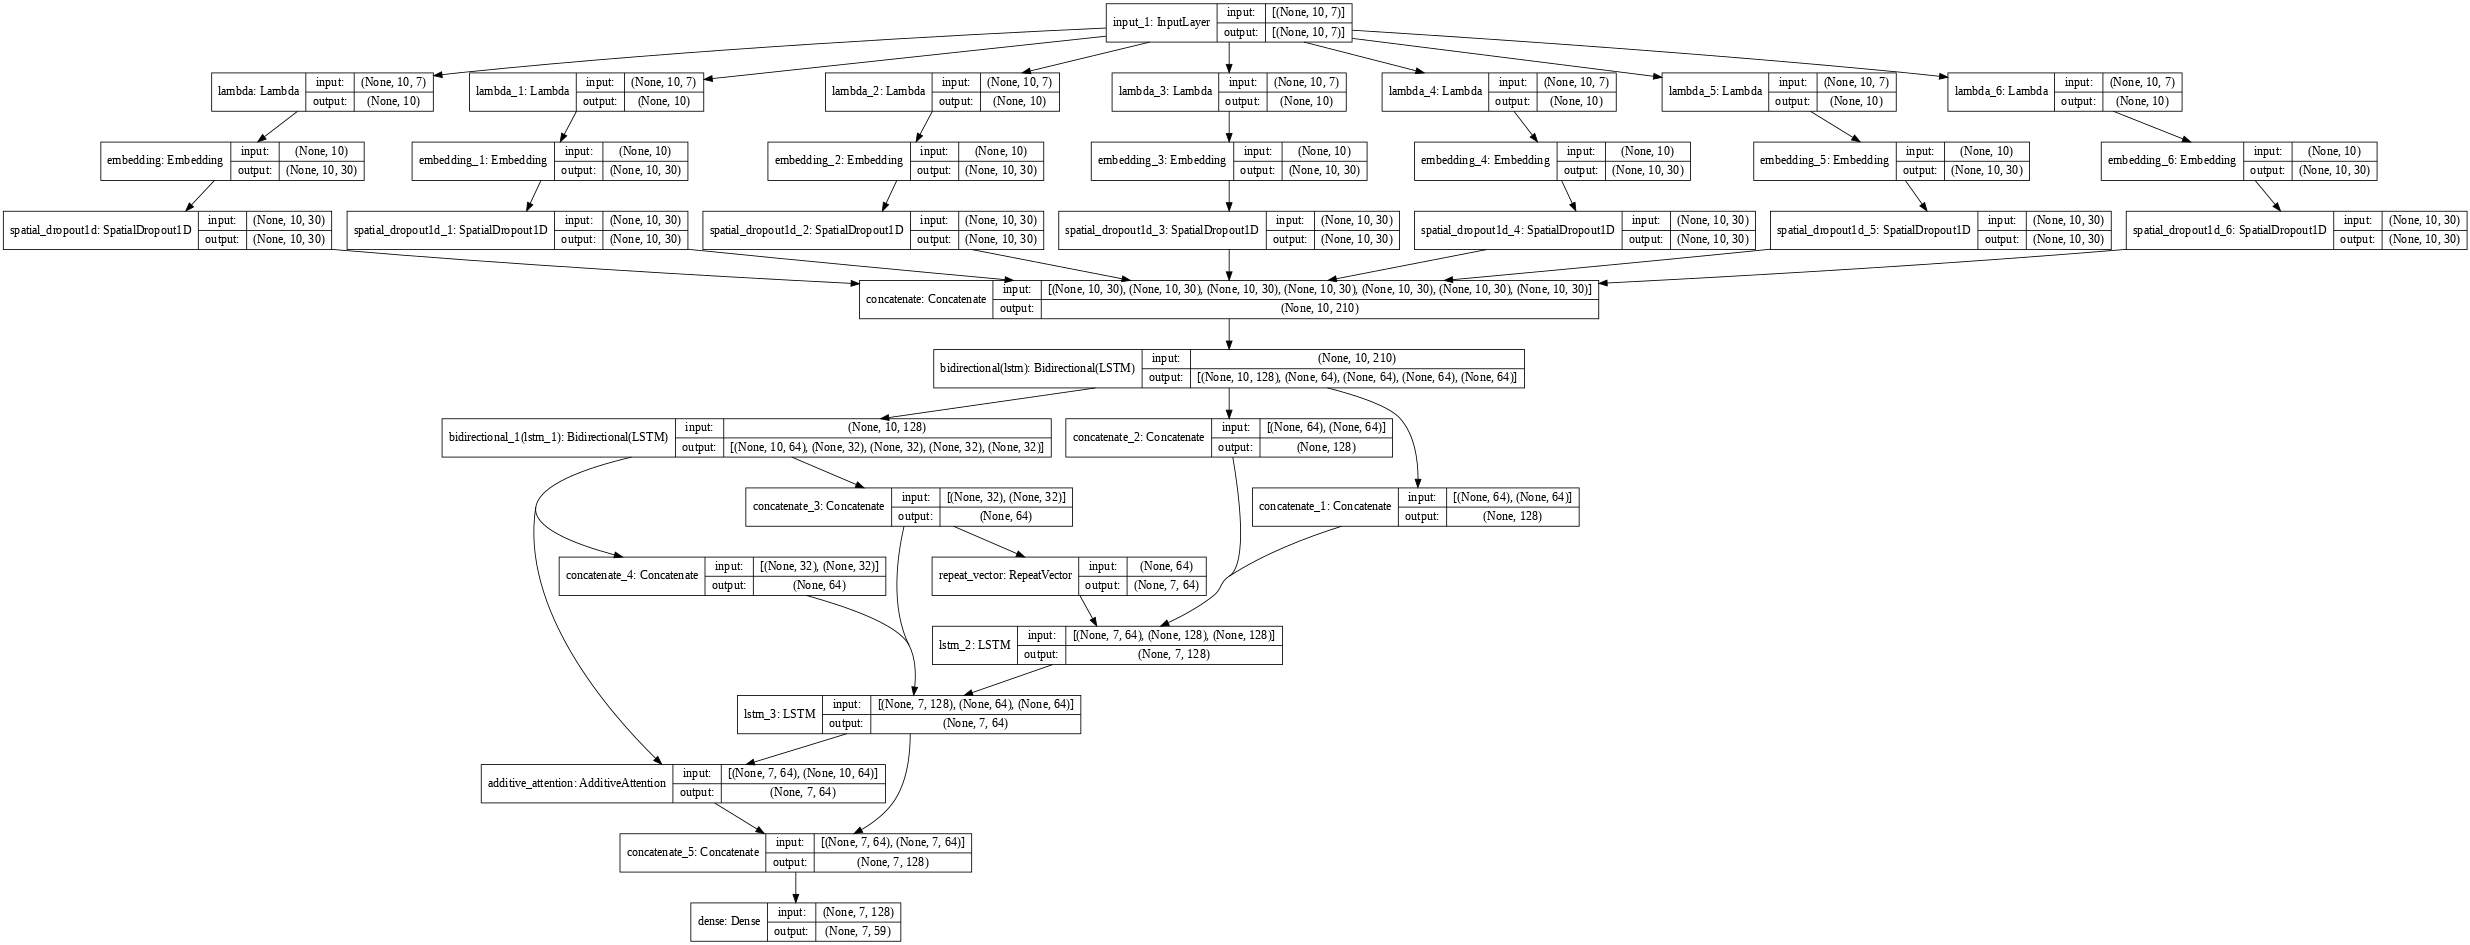

In [10]:
%matplotlib inline
plot_model(model, show_shapes = True, show_layer_names = True, rankdir = 'TB', dpi = 60)

Commence the training session

In [11]:
class CosineAnnealingScheduler(callbacks.Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min = 0, verbose = 0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs = None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        backend.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs = None):
        logs = logs or {}
        logs['lr'] = backend.get_value(self.model.optimizer.lr)

In [12]:
EPOCHS = 200
BATCH_SIZE = 32
LR_MAX = 1e-4
LR_MIN = 1e-5

cas = CosineAnnealingScheduler(EPOCHS, LR_MAX, LR_MIN)

ckp = callbacks.ModelCheckpoint('best_model.hdf5', monitor = 'val_sparse_top_k', verbose = 0, 
                                save_best_only = True, save_weights_only = False, mode = 'max')

history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test), 
                    callbacks = [ckp, cas], 
                    epochs = EPOCHS, 
                    batch_size = BATCH_SIZE, 
                    verbose = 2)

hist = pd.DataFrame(history.history)

Epoch 1/200
14/14 - 37s - loss: 4.0779 - sparse_top_k: 0.0790 - val_loss: 4.0775 - val_sparse_top_k: 0.0886
Epoch 2/200
14/14 - 1s - loss: 4.0768 - sparse_top_k: 0.0971 - val_loss: 4.0773 - val_sparse_top_k: 0.0829
Epoch 3/200
14/14 - 1s - loss: 4.0762 - sparse_top_k: 0.1012 - val_loss: 4.0771 - val_sparse_top_k: 0.1029
Epoch 4/200
14/14 - 1s - loss: 4.0762 - sparse_top_k: 0.1015 - val_loss: 4.0768 - val_sparse_top_k: 0.1114
Epoch 5/200
14/14 - 1s - loss: 4.0750 - sparse_top_k: 0.1113 - val_loss: 4.0765 - val_sparse_top_k: 0.1171
Epoch 6/200
14/14 - 1s - loss: 4.0744 - sparse_top_k: 0.1160 - val_loss: 4.0760 - val_sparse_top_k: 0.1229
Epoch 7/200
14/14 - 1s - loss: 4.0734 - sparse_top_k: 0.1247 - val_loss: 4.0754 - val_sparse_top_k: 0.1057
Epoch 8/200
14/14 - 1s - loss: 4.0721 - sparse_top_k: 0.1375 - val_loss: 4.0745 - val_sparse_top_k: 0.1086
Epoch 9/200
14/14 - 1s - loss: 4.0705 - sparse_top_k: 0.1365 - val_loss: 4.0732 - val_sparse_top_k: 0.1171
Epoch 10/200
14/14 - 1s - loss: 4.06

0.2257142812013626


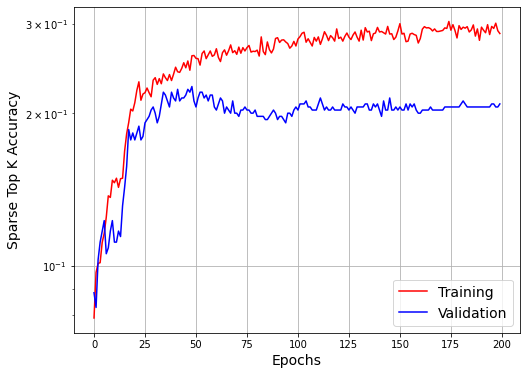

In [13]:
print(hist['val_sparse_top_k'].max())

plt.figure(figsize = (8, 6))
plt.semilogy(hist['sparse_top_k'], '-r', label = 'Training')
plt.semilogy(hist['val_sparse_top_k'], '-b', label = 'Validation')
plt.ylabel('Sparse Top K Accuracy', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
plt.legend(fontsize = 14)
plt.grid()
plt.show()

Predict the test dataset

In [14]:
model.load_weights('best_model.hdf5')
pred = model.predict(X_test)
pred = np.argmax(pred, axis = 2)

for i in range(y_test.shape[0]):
    print('Prediction:\t', pred[i] + 1)
    print('GoundTruth:\t', y_test[i] + 1)
    print('-' * 40)

Prediction:	 [ 2 14 29 39 54 58 58]
GoundTruth:	 [ 4  7 14 19 50 56  8]
----------------------------------------
Prediction:	 [ 2 14 29 41 58 58 58]
GoundTruth:	 [ 5 29 35 36 40 44 42]
----------------------------------------
Prediction:	 [ 2 14 29 39 54 58 58]
GoundTruth:	 [10 39 45 46 52 54 12]
----------------------------------------
Prediction:	 [ 2 14 29 39 54 58 58]
GoundTruth:	 [ 7 22 30 38 42 47 14]
----------------------------------------
Prediction:	 [ 2 14 29 39 54 58 58]
GoundTruth:	 [ 3  7 11 19 27 52  5]
----------------------------------------
Prediction:	 [ 2 14 29 41 54 58 58]
GoundTruth:	 [12 26 29 34 56 58 41]
----------------------------------------
Prediction:	 [ 2 14 29 41 54 58 58]
GoundTruth:	 [11 24 25 39 53 57  9]
----------------------------------------
Prediction:	 [ 2 14 29 36 54 58 58]
GoundTruth:	 [ 8 14 27 33 46 49 11]
----------------------------------------
Prediction:	 [ 2  8 29 36 54 58 58]
GoundTruth:	 [ 4 16 17 22 27 52 30]
------------------------

Predict the Future Draw on 2020/Aug/26

In [15]:
X_latest = X_test[-1][1:]
X_latest = np.concatenate([X_latest, y_test[-1].reshape(1, 7)], axis = 0)
X_latest = X_latest.reshape(1, X_latest.shape[0], X_latest.shape[1])
print(X_latest + 1)

[[[ 2  7 11 23 37 45 19]
  [10 13 14 18 33 34 15]
  [ 1 24 39 46 49 52 51]
  [ 4 10 13 24 53 56 22]
  [ 1 28 42 43 51 58 36]
  [ 2 40 49 53 56 58 41]
  [ 6  8 27 31 37 51 20]
  [10 14 16 22 25 34 21]
  [21 22 32 36 45 50  5]
  [19 23 24 28 37 51 12]]]


In [16]:
# beam search
def beam_search_decoder(data, k, replace = True):
    sequences = [[list(), 0.0]]
    # walk over each step in sequence
    for row in data:
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            best_k = np.argsort(row)[-k:]
            for j in best_k:
                candidate = [seq + [j], score + math.log(row[j])]
                if replace:
                    all_candidates.append(candidate)
                elif (replace == False) and (len(set(candidate[0])) == len(candidate[0])):
                    all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key = lambda tup:tup[1], reverse = True)
        # select k best
        sequences = ordered[:k]
    return sequences

In [17]:
pred_latest = model.predict(X_latest)
pred_latest = np.squeeze(pred_latest)
pred_latest_greedy = np.argmax(pred_latest, axis = 1)
print(pred_latest_greedy + 1)

[ 2 14 29 41 54 58 58]


In [18]:
beam_width = 10
replace = True

result = beam_search_decoder(pred_latest, beam_width, replace)
print('Beam Width:\t', beam_width)
print('Replace:\t', replace)
print('-' * 85)
for seq in result:
    print('Prediction: ', np.array(seq[0]) + 1, '\tLog Likelihood: ', seq[1])

Beam Width:	 10
Replace:	 True
-------------------------------------------------------------------------------------
Prediction:  [ 2 14 29 41 54 58 58] 	Log Likelihood:  -20.775675253971364
Prediction:  [ 2 14 29 36 54 58 58] 	Log Likelihood:  -20.77603168228151
Prediction:  [ 2 14 29 39 54 58 58] 	Log Likelihood:  -20.804108773180626
Prediction:  [ 5 14 29 41 54 58 58] 	Log Likelihood:  -20.826897398552312
Prediction:  [ 5 14 29 36 54 58 58] 	Log Likelihood:  -20.827253826862457
Prediction:  [ 4 14 29 41 54 58 58] 	Log Likelihood:  -20.835650866470115
Prediction:  [ 4 14 29 36 54 58 58] 	Log Likelihood:  -20.83600729478026
Prediction:  [ 2 14 29 35 54 58 58] 	Log Likelihood:  -20.845043362116837
Prediction:  [ 2 14 29 37 54 58 58] 	Log Likelihood:  -20.851207724229464
Prediction:  [ 2 14 29 41 58 58 58] 	Log Likelihood:  -20.855280222952477


In [19]:
beam_width = 10
replace = False

result = beam_search_decoder(pred_latest, beam_width, replace)
print('Beam Width:\t', beam_width)
print('Replace:\t', replace)
print('-' * 85)
for seq in result:
    print('Prediction: ', np.array(seq[0]) + 1, '\tLog Likelihood: ', seq[1])

Beam Width:	 10
Replace:	 False
-------------------------------------------------------------------------------------
Prediction:  [ 2 14 29 41 54 58 55] 	Log Likelihood:  -20.89786440993707
Prediction:  [ 2 14 29 36 54 58 55] 	Log Likelihood:  -20.898220838247216
Prediction:  [ 2 14 29 39 54 58 55] 	Log Likelihood:  -20.926297929146333
Prediction:  [ 2 14 29 41 54 55 58] 	Log Likelihood:  -20.937513228991953
Prediction:  [ 5 14 29 41 54 58 55] 	Log Likelihood:  -20.94908655451802
Prediction:  [ 5 14 29 36 54 58 55] 	Log Likelihood:  -20.949442982828163
Prediction:  [ 4 14 29 41 54 58 55] 	Log Likelihood:  -20.95784002243582
Prediction:  [ 4 14 29 36 54 58 55] 	Log Likelihood:  -20.958196450745966
Prediction:  [ 2 14 29 35 54 58 55] 	Log Likelihood:  -20.967232518082543
Prediction:  [ 2 14 29 37 54 58 55] 	Log Likelihood:  -20.97339688019517
